In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
pip install filterpy


In [26]:
pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 7.9 MB/s eta 0:00:00


Lọc dữ liệu với Publication_day = Sunday


In [45]:
import pandas as pd

# Tải dữ liệu
df = pd.read_csv("/content/drive/MyDrive/Time_series/TH1/test.csv")

# Lọc dữ liệu chỉ lấy các dòng có Publication_day là 'Sunday'
df_filtered = df[df["Publication_Day"] == "Sunday"]

# Tính giá trị trung bình của 'Episode_Length_minutes' cho 'Sunday'
mean_episode_length = df_filtered["Episode_Length_minutes"].mean()

# Thay thế NaN và giá trị trống bằng giá trị trung bình
df_filtered["Episode_Length_minutes"].fillna(mean_episode_length, inplace=True)

# Lấy cột giá trị quan sát (numerical representation)
observations = df_filtered["Episode_Length_minutes"].values

# Loại bỏ các giá trị inf
observations = observations[np.isfinite(observations)]



<ipython-input-45-4ce1e95ba099>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered["Episode_Length_minutes"].fillna(mean_episode_length, inplace=True)
<ipython-input-45-4ce1e95ba099>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Episode_Length_minutes"].fillna(mean_episode_length, inplace=True)


Mô hình 1: Mô hình Kalman tiêu chuẩn

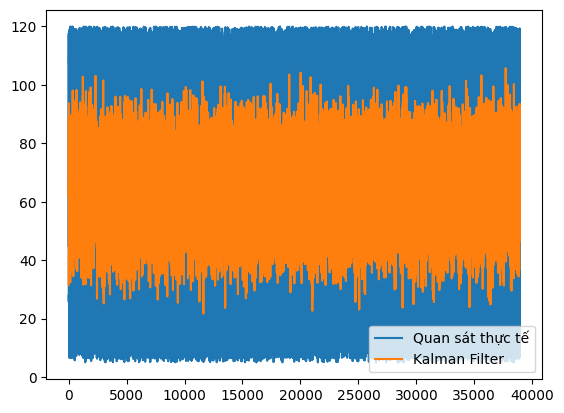

In [46]:
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
kf = kf.em(observations, n_iter=10)

filtered_state_means, _ = kf.filter(observations)

plt.plot(observations, label="Quan sát thực tế")
plt.plot(filtered_state_means, label="Kalman Filter")
plt.legend()
plt.show()

Mô hình 2: Mô hình Kalman mở rộng (Extended Kalman Filter - EKF)



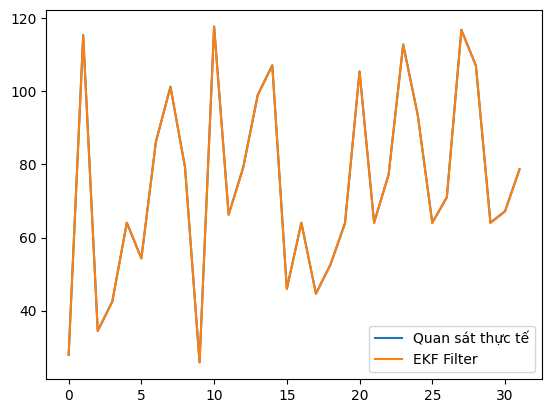

In [47]:
import numpy as np
from filterpy.kalman import ExtendedKalmanFilter

def fx(x, dt):
    return x + dt * np.sin(x)

def hx(x):
    return np.array([x])

# Define the Jacobian of the measurement function
def HJacobian(x):
    return np.array([[1.]])

ekf = ExtendedKalmanFilter(dim_x=1, dim_z=1)
ekf.x = np.array([0.])
ekf.F = np.array([[1.]])
ekf.H = np.array([[1.]])
ekf.P *= 1000
ekf.R = np.array([[5.]])
ekf.Q = np.array([[0.1]])

filtered_results = []
# Reset the filter state before each update
for z in observations[:32]:
    ekf.x = np.array([0.]) # Reset the state
    ekf.P *= 1000  # Reset the covariance
    ekf.predict()
    # Pass HJacobian and hx to the update method
    ekf.update(np.array([z]), HJacobian=HJacobian, Hx=hx)
    filtered_results.append(ekf.x[0])

plt.plot(observations[:32], label="Quan sát thực tế") # Plot limited observations
plt.plot(filtered_results, label="EKF Filter")
plt.legend()
plt.show()

Mô hình 3: Mô hình Kalman theo phân phối xác suất (Unscented Kalman Filter - UKF)

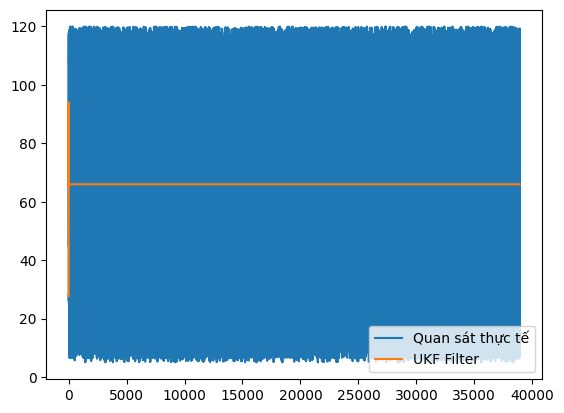

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.kalman import MerweScaledSigmaPoints

def fx(x, dt):
    return x + dt * np.sin(x)

def hx(x):
    return x

points = MerweScaledSigmaPoints(n=1, alpha=.1, beta=2., kappa=0.)
ukf = UnscentedKalmanFilter(dim_x=1, dim_z=1, dt=1, fx=fx, hx=hx, points=points)

ukf.x = np.array([0.])
ukf.P *= 1000
ukf.R = np.array([[5.]])
ukf.Q = np.array([[0.1]])

filtered_results = []
for z in observations:
    ukf.predict()
    ukf.update(np.array([z]))
    filtered_results.append(ukf.x[0])

plt.plot(observations, label="Quan sát thực tế")
plt.plot(filtered_results, label="UKF Filter")
plt.legend()
plt.show()